Funds Rate dataset from [FRED Economic](https://fred.stlouisfed.org/series/FEDFUNDS) Data website. 

In [5]:
import warnings       
import numpy as np                           
import pandas as pd                          
import matplotlib.pyplot as plt    
import seaborn as sns
import os
warnings.filterwarnings('ignore')


In [64]:
pwd = os.getcwd()
# df   = pd.read_csv(os.path.basename(pwd + '/FEDFUNDS.csv'))
df   = pd.read_csv(os.path.basename(pwd + '/FEDFUNDS.csv'),
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )


df.head(5)

,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


In [65]:
df.unstack().head()

          DATE      
FEDFUNDS  1954-07-01   0.80
          1954-08-01   1.22
          1954-09-01   1.07
          1954-10-01   0.85
          1954-11-01   0.83
dtype: float32

In [66]:
# df.head().values

In [67]:
# df.unstack().head().values

In [68]:
# create a time series
s = pd.Series(df.unstack().values, index=df.index)

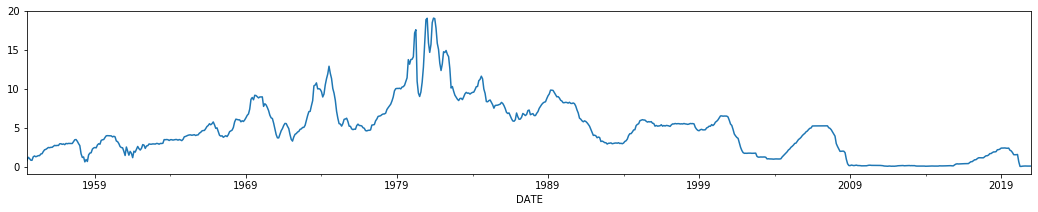

In [69]:
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20
s.plot()

In [70]:
s[:'2007'].tail(10)

DATE
2007-03-01   5.26
2007-04-01   5.25
2007-05-01   5.25
2007-06-01   5.25
2007-07-01   5.26
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
dtype: float32

In [71]:


# keep only data before 2008 
s = s[:'2007']
s.head()


DATE
1954-07-01   0.80
1954-08-01   1.22
1954-09-01   1.07
1954-10-01   0.85
1954-11-01   0.83
dtype: float32

In [72]:
# calculate descriptive statistics
s.describe()

count   642.00
mean      5.69
std       3.32
min       0.63
25%       3.30
50%       5.25
75%       7.30
max      19.10
dtype: float64

In [73]:
# query a dataset using a date-time index
s['1999-06':'2000-06']


DATE
1999-06-01   4.76
1999-07-01   4.99
1999-08-01   5.07
1999-09-01   5.22
1999-10-01   5.20
1999-11-01   5.42
1999-12-01   5.30
2000-01-01   5.45
2000-02-01   5.73
2000-03-01   5.85
2000-04-01   6.02
2000-05-01   6.27
2000-06-01   6.53
dtype: float32

In [76]:

df1 = pd.DataFrame()
df1['year'] =  [s.index[i].year for i in range(len(s))]
df1['month'] = [s.index[i].month for i in range(len(s))]
df1['value'] = s.values.tolist()


In [77]:

df1.head()


,year,month,value
0,1954,7,0.80
1,1954,8,1.22
2,1954,9,1.07
3,1954,10,0.85
4,1954,11,0.83


In [78]:
values = pd.DataFrame(s.values)
df1 = pd.concat([values.shift(1), values], axis=1)
df1.columns = ['t', 't+1']

In [79]:
df1.head()

,t,t+1
0,NaN,0.80
1,0.80,1.22
2,1.22,1.07
3,1.07,0.85
4,0.85,0.83


In [81]:
df1.tail()

,t,t+1
637,5.26,5.02
638,5.02,4.94
639,4.94,4.76
640,4.76,4.49
641,4.49,4.24


###  Window feature

In [82]:
values = pd.DataFrame(s.values)
df1 = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df1.columns = ['t-2', 't-1', 't', 't+1']

In [83]:
df1.head()

,t-2,t-1,t,t+1
0,NaN,NaN,NaN,0.80
1,NaN,NaN,0.80,1.22
2,NaN,0.80,1.22,1.07
3,0.80,1.22,1.07,0.85
4,1.22,1.07,0.85,0.83


In [85]:
df1.tail()

,t-2,t-1,t,t+1
637,5.25,5.25,5.26,5.02
638,5.25,5.26,5.02,4.94
639,5.26,5.02,4.94,4.76
640,5.02,4.94,4.76,4.49
641,4.94,4.76,4.49,4.24


In [87]:
#Rolling Window Statistics (Add a summary of the values at previous time steps)
values = pd.DataFrame(s.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df1 = pd.concat([means, values], axis=1)
df1.columns = ['mean(t-1,t)', 't+1']

In [88]:
df1.head()

,"mean(t-1,t)",t+1
0,NaN,0.80
1,NaN,1.22
2,1.01,1.07
3,1.15,0.85
4,0.96,0.83


In [89]:
df1.tail()

,"mean(t-1,t)",t+1
637,5.26,5.02
638,5.14,4.94
639,4.98,4.76
640,4.85,4.49
641,4.62,4.24


In [90]:
values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df1 = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df1.columns = ['min', 'mean', 'max', 't+1']

In [91]:
df1.head()

,min,mean,max,t+1
0,NaN,NaN,NaN,0.80
1,NaN,NaN,NaN,1.22
2,NaN,NaN,NaN,1.07
3,NaN,NaN,NaN,0.85
4,0.80,1.03,1.22,0.83


In [92]:
df1.tail()

,min,mean,max,t+1
637,5.25,5.25,5.25,5.02
638,5.25,5.25,5.26,4.94
639,5.02,5.18,5.26,4.76
640,4.94,5.07,5.26,4.49
641,4.76,4.91,5.02,4.24


In [93]:
#Expanding Window Statistics
values = pd.DataFrame(s.values)
window = values.expanding()

df1 = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df1.columns = ['min', 'mean', 'max', 't+1']

In [94]:
df1.head()

,min,mean,max,t+1
0,0.80,0.80,0.80,0.80
1,0.80,1.01,1.22,1.22
2,0.80,1.03,1.22,1.07
3,0.80,0.99,1.22,0.85
4,0.80,0.95,1.22,0.83


In [95]:
df1.tail()

,min,mean,max,t+1
637,0.63,5.70,19.10,5.02
638,0.63,5.70,19.10,4.94
639,0.63,5.69,19.10,4.76
640,0.63,5.69,19.10,4.49
641,0.63,5.69,19.10,4.24


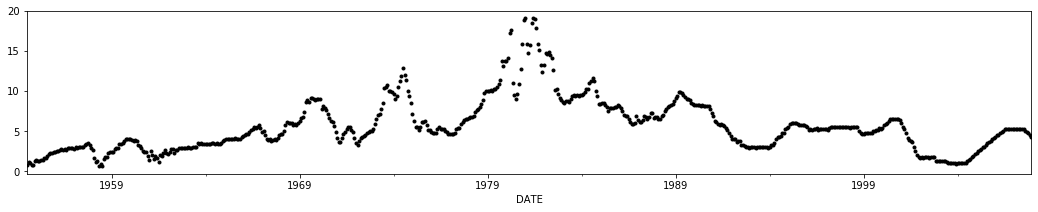

In [96]:
# Data Visualization
s.plot(style='k.')

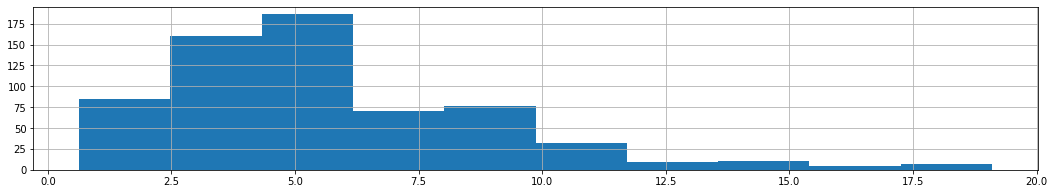

In [97]:
s.hist()

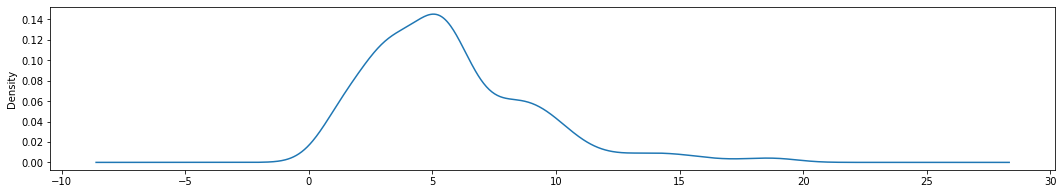

In [98]:
s.plot(kind='kde')